# ResNet50

In [1]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import random
from scipy.stats import pointbiserialr
from  sklearn.preprocessing import OrdinalEncoder
import h5py
import os

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Image Processing
import cv2
from PIL import Image
from io import BytesIO
from skimage.feature import hog

# Deep Learning Modules
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")

#### Feature extraction

read metadata for image path

In [2]:
df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
df.head(5)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [3]:
path_list = [f"/kaggle/input/isic-2024-challenge/train-image/image/{id}.jpg" for id in df.isic_id]
selected_images = np.random.choice(path_list, 3, replace=False)

#### Hair removal

In [4]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    return final_image

show the difference between raw image and hair removal image

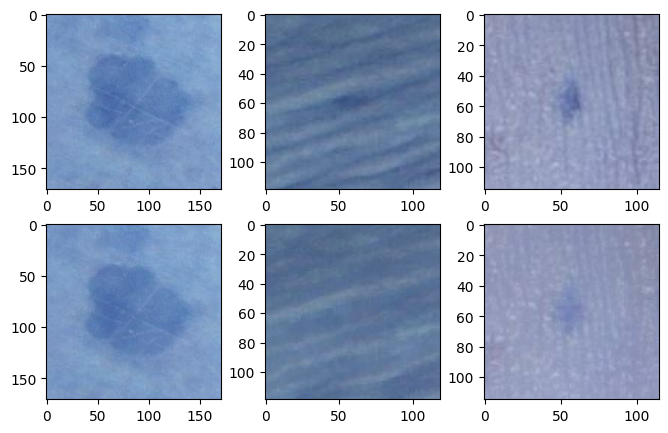

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
for i, path in enumerate(selected_images):
    image = cv2.imread(path)
    axes[0, i].imshow(image)
    axes[1, i].imshow(hair_remove(image))

#### SIFT

In [6]:
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    sift_image = cv2.drawKeypoints(image, keypoints, None)
    return sift_image

show the difference between raw image and sift image

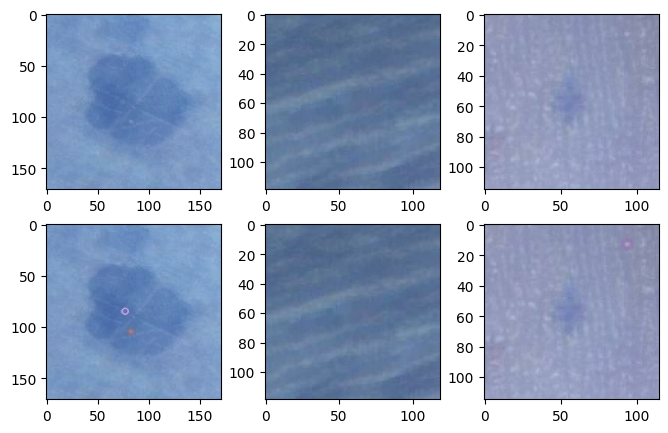

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
for i, path in enumerate(selected_images):
    image = cv2.imread(path)
    image_no_hair = hair_remove(image)
    axes[0, i].imshow(image_no_hair)
    axes[1, i].imshow(extract_sift_features(image_no_hair))

#### HOG

In [8]:
def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_image

show the difference between raw image and hog image

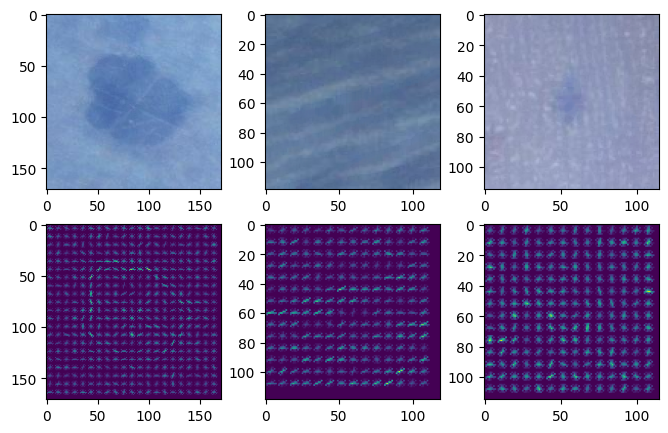

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
for i, path in enumerate(selected_images):
    image = cv2.imread(path)
    image_no_hair = hair_remove(image)
    axes[0, i].imshow(image_no_hair)
    axes[1, i].imshow(extract_hog_features(image_no_hair))

____

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
df["path_list"] = pd.Series(path_list)
melanoma = df[df["target"] == 1]
nonmelanoma = df[df["target"] == 0].sample(len(melanoma) * 3)

<Axes: xlabel='target', ylabel='count'>

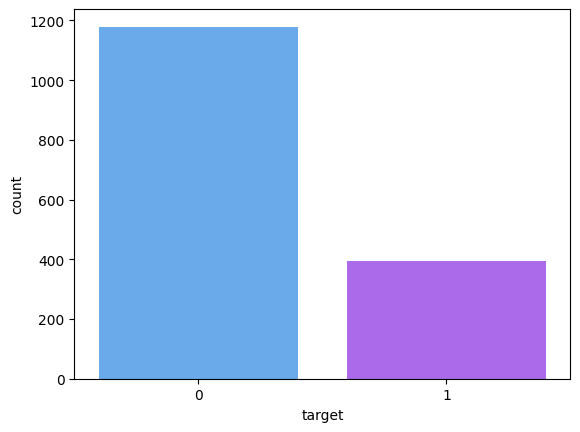

In [6]:
Data = pd.concat([melanoma, nonmelanoma], axis = 0).reset_index(drop = True)
df = Data[["path_list", "target"]]
sns.countplot(x = Data["target"], palette = "cool")

#### Define transforms and dataset

In [7]:
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(255),
    transforms.ColorJitter(brightness=0.75, contrast=0.75),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(255),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
class FlowerDataset(Dataset):
    
    def __init__(self, df, transform = None, Test_mode = False):
        
        self.df = df.reset_index(drop = True)
        self.path = self.df.iloc[:, 0]
        
        self.test_mode = Test_mode
        if self.test_mode == False:
            self.target = self.df.iloc[:, 1]
        self.transform = transform
        
    def __getitem__(self, index):

        img = Image.open(self.path[index])

        
        if transform is not None:
            
            img = transform(img)
            
        target = self.target[index]
        
        
        if self.test_mode == False:
            
            return img, target
        else:
            return img
       
    
    def __len__(self):
        
        return len(self.path)

#### Sample and split data

In [10]:
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df.iloc[:, 1] = label_encoder.fit_transform(df.iloc[:, 1])

# Mostrar los nombres de las clases y sus correspondientes etiquetas numéricas
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Clase: {class_name}, Etiqueta: {i}")


Train, Test = tts(df, test_size = 0.01/2, stratify = df.iloc[:, 1])
Train, Valid = tts(Train, test_size = 0.1, stratify = Train.iloc[:, 1])

print(f"Train Shape is: {Train.shape}")
print(f"Valid Shape is: {Valid.shape}")
print(f"Test Shape is: {Test.shape}")

print(f"Validation and Test Len is {(Valid.shape[0]  + Test.shape[0]) / df.shape[0] :.2%}")

train_ds = FlowerDataset(Train, transform)
valid_ds = FlowerDataset(Valid, transform_test)
test_ds = FlowerDataset(Test, transform_test)

train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 32, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = 32, shuffle = False)

Clase: 0, Etiqueta: 0
Clase: 1, Etiqueta: 1
Train Shape is: (1407, 2)
Valid Shape is: (157, 2)
Test Shape is: (8, 2)
Validation and Test Len is 10.50%


#### Define train and valid functions

In [15]:
# Training function
def train(model, optimizer, criterion, train_dl, valid_dl, epochs):
    result = []
    val_res = []

    for e in range(epochs):
        print(f"Training the Epoch: {e + 1}")
        model.train()
        total_loss = 0
        total = 0
        correct = 0
        
        for X_train, y_train in train_dl:
            X_train, y_train = X_train.to(device).float(), y_train.to(device).long()
            
            y_pred = model(X_train)
            if isinstance(y_pred, tuple):  # In case of Inception
                y_pred = y_pred[0]
                
            loss = criterion(y_pred, y_train)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y_train.size(0)
            correct += (predicted == y_train).sum().item()
            
        acc_train = 100 * correct / total
        _, val_acc = valid(model, valid_dl, device)
        
        print(f'Epoch: [{e+1}/{epochs}], Loss: {total_loss / total:.4f}, Train Acc: {acc_train:.2f}, Val Acc: {val_acc:.2f}')
        result.append(acc_train)
        val_res.append(val_acc)
    
    # Save results to files
    np.savetxt('result.csv', np.array(result), fmt='%.2f', delimiter=',')
    np.savetxt('val_result.csv', np.array(val_res), fmt='%.2f', delimiter=',')  
    
    
    
# Validation Function
def valid(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sample, target in val_loader:
            sample = sample.to(device).float()
            target = target.to(device).long()
            outputs = model(sample)
            _, predicted = torch.max(outputs.data, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_accuracy = 100 * correct / total
    return [], val_accuracy

def plot():
    train_data = np.loadtxt('result.csv', delimiter=',')
    val_data = np.loadtxt('val_result.csv', delimiter=',')
    plt.figure()
    plt.plot(range(1, len(train_data) + 1), train_data, color='blue', label='Train')
    plt.plot(range(1, len(val_data) + 1), val_data, color='red', label='Validation')
    plt.legend()
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.title('Train and Validation Accuracy', fontsize=16)
    plt.savefig('plot.png')
    plt.show()

#### Use pretrained ResNet model

In [13]:
from torchvision import models
Resnet50 = models.resnet50(pretrained = True)

#### Define predict function

In [16]:
# Common normalization values used for RGB images in PyTorch
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to denormalize an image
def denormalize(image, mean, std):
    image = image.clone()  # Create a copy to avoid modifying the original
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)  # Denormalize
    return image

def preds(Model):
    # Example: get a batch of data
    images, targets = next(iter(test_dl))  
    indices = np.arange(len(images))
    np.random.shuffle(indices)

    fig, axes = plt.subplots(8, 2, figsize=(15, 24))  # 16 rows and 2 columns (image and bar plot)
    axes = axes.ravel()

    # Set black background color for all subplots
    for ax in axes:
        ax.set_facecolor('black')

    # Set black background color for the whole figure
    fig.patch.set_facecolor('black')

    # Invert the LabelEncoder dictionary to map integers to labels
    int_to_label = {i: label for i, label in enumerate(label_encoder.classes_)}

    # Calculate accuracy
    correct_predictions = {label: 0 for label in int_to_label.values()}
    total_predictions = {label: 0 for label in int_to_label.values()}

    # Limit the number of iterations to the available number of subplots
    for i in range(min(len(indices), len(axes) // 2)):
        idx = indices[i]
        image, actual_target = images[idx], targets[idx]
        image_tensor = image.to(device).unsqueeze(0)
        output = Model(image_tensor)
        _, prediction = torch.max(output, 1)

        predicted_label = int_to_label[prediction.cpu().item()]  # Convert to class name
        actual_label = int_to_label[actual_target.item()]
        total_predictions[actual_label] += 1
        if predicted_label == actual_label:
            correct_predictions[predicted_label] += 1

        # Convert the image tensor for plotting
        image = denormalize(image, mean, std)
        image = image.permute(1, 2, 0)  # Change dimensions from CxHxW to HxWxC
        image = image.cpu().numpy()

        # Display image
        axes[2 * i].imshow(image)
        axes[2 * i].set_title(f"Actual Label: {actual_label}", color='white')
        axes[2 * i].axis('off')

        # Display bar plot with probabilities
        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy().flatten()
        bar_colors = ['white'] * len(probabilities)  # Default bar colors

        # Change bar colors based on conditions
        if predicted_label == actual_label:
            bar_colors[np.argmax(probabilities)] = 'aquamarine'  # Correct prediction
        else:
            bar_colors[np.argmax(probabilities)] = 'red'  # Incorrect prediction
            bar_colors[list(int_to_label.values()).index(actual_label)] = 'steelblue'  # Correct label

        axes[2 * i + 1].bar(int_to_label.values(), probabilities, color=bar_colors)
        axes[2 * i + 1].set_ylim(0, 1)
        axes[2 * i + 1].set_title(f"Probabilities for {predicted_label}", color='white')

        # Configure axis colors and annotations
        axes[2 * i + 1].tick_params(axis='x', colors='white')
        axes[2 * i + 1].tick_params(axis='y', colors='white')
        axes[2 * i + 1].spines['bottom'].set_color('white')
        axes[2 * i + 1].spines['top'].set_color('white') 
        axes[2 * i + 1].spines['right'].set_color('white')
        axes[2 * i + 1].spines['left'].set_color('white')
        axes[2 * i + 1].yaxis.label.set_color('white')
        axes[2 * i + 1].xaxis.label.set_color('white')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


In [17]:
for param in Resnet50.parameters():
    param.requires_grad = False
    
features = Resnet50.fc.in_features
Resnet50.fc = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Model = Resnet50.to(device)



optimizer = optim.SGD(Model.parameters(), lr = 0.003, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

train(Model, optimizer, criterion, train_dl, valid_dl, 20)
plot()
preds(Model)

Training the Epoch: 1


KeyboardInterrupt: 

#### Stratified 20-folds cross validation

cv method which focuses on imbalance data

In [24]:
# check the data splitted at the beginning
Train

,path_list,target
566,./isic-2024-challenge/train-image/image/ISIC_9...,0
304,./isic-2024-challenge/train-image/image/ISIC_7...,1
1320,./isic-2024-challenge/train-image/image/ISIC_5...,0
661,./isic-2024-challenge/train-image/image/ISIC_7...,0
1316,./isic-2024-challenge/train-image/image/ISIC_5...,0
...,...,...
1179,./isic-2024-challenge/train-image/image/ISIC_8...,0
659,./isic-2024-challenge/train-image/image/ISIC_5...,0
269,./isic-2024-challenge/train-image/image/ISIC_6...,1
330,./isic-2024-challenge/train-image/image/ISIC_8...,1


In [16]:
# a new train function without save the results

def train(model, optimizer, criterion, train_dl, valid_dl, epochs):
    result = []
    val_res = []

    for e in range(epochs):
        print(f"Training the Epoch: {e + 1}")
        model.train()
        print("haha")
        total_loss = 0
        total = 0
        correct = 0
        
        for X_train, y_train in train_dl:
            X_train, y_train = X_train.to(device).float(), y_train.to(device).long()
            print("come on")
            y_pred = model(X_train)
            if isinstance(y_pred, tuple):  # In case of Inception
                y_pred = y_pred[0]
                
            loss = criterion(y_pred, y_train)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y_train.size(0)
            correct += (predicted == y_train).sum().item()
            
        acc_train = 100 * correct / total
        _, val_acc = valid(model, valid_dl, device)
        
        print(f'Epoch: [{e+1}/{epochs}], Loss: {total_loss / total:.4f}, Train Acc: {acc_train:.2f}, Val Acc: {val_acc:.2f}')
        result.append(acc_train)
        val_res.append(val_acc)
    
    return val_res

Define stratified 20-folds cross validation from scratch

In [31]:
def stratified_kfold_cv(df, model, fraction, n_splits):
    """
    从零实现分层交叉验证，适用于图片数据集
    df: 包含图片路径和标签的数据集
    n_repeats: 重复次数
    """
    sample_df = df.sample(frac=fraction)

    # Step 2: 按类别分层划分样本数据为 n_splits 份，确保类别比例不变
    classes = np.unique(sample_df.iloc[:, 1])  # 获取类别 col 1
    fold_indices = {i: [] for i in range(n_splits)}  # 初始化每个折的索引存储

    for cls in classes:
        cls_indices = np.where(sample_df.iloc[:, 1] == cls)[0]  # 获取每个类别的索引
        np.random.shuffle(cls_indices)  # 打乱顺序
        cls_fold_size = len(cls_indices) // n_splits  # 每一份的大小

        # 将该类别的样本均匀分布到各个折
        for i in range(n_splits):
            start = i * cls_fold_size
            end = (i + 1) * cls_fold_size if i != n_splits - 1 else len(cls_indices)  # 最后一折包括所有剩余样本
            fold_indices[i].extend(cls_indices[start:end])

    all_results = []

    for i in range(n_splits):
        valid_idx = fold_indices[i]  # 当前的第i折作为验证集
        train_idx = np.concatenate([fold_indices[j] for j in range(n_splits) if j != i])  # 其他作为训练集
        
        Valid = sample_df.iloc[valid_idx]
        Train = sample_df.iloc[train_idx]

        train_ds = FlowerDataset(Train, transform)
        valid_ds = FlowerDataset(Valid, transform_test)

        train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
        valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)

        # 在该折上训练
        val_res = train(model, optimizer, criterion, train_dl, valid_dl, 20)
            
        # 预测验证集
        # predictions, actuals = preds(model, test_dl, device)
        # predictions = np.array(predictions, dtype=int)
        # actuals = np.array(actuals, dtype=int)
            
        # 存储本次折的结果（以准确率为例）
        # fold_result = np.mean(predictions == actuals)  # 替换为实际的评估指标
        all_results.append(val_res)
    
    # 计算 20 次实验的均值和方差
    mean_result = np.mean(all_results)
    variance_result = np.var(all_results)
    
    print(f"\n最终结果：\n均值 = {mean_result}, 方差 = {variance_result}")
    return mean_result, variance_result


#### Run stratified cross validation

In [21]:
for param in Resnet50.parameters():
    param.requires_grad = False
    
features = Resnet50.fc.in_features
Resnet50.fc = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Model = Resnet50.to(device)



optimizer = optim.SGD(Model.parameters(), lr = 0.003, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [33]:
mean, variance = stratified_kfold_cv(df=df, model=Model, fraction=0.1, n_splits=20)

Training the Epoch: 1
Epoch: [1/3], Loss: 0.0228, Train Acc: 78.67, Val Acc: 57.14
Training the Epoch: 2
Epoch: [2/3], Loss: 0.0184, Train Acc: 75.33, Val Acc: 85.71
Training the Epoch: 3
Epoch: [3/3], Loss: 0.0203, Train Acc: 80.67, Val Acc: 100.00
Training the Epoch: 1
Epoch: [1/3], Loss: 0.0175, Train Acc: 76.00, Val Acc: 85.71
Training the Epoch: 2
Epoch: [2/3], Loss: 0.0164, Train Acc: 80.00, Val Acc: 100.00
Training the Epoch: 3
Epoch: [3/3], Loss: 0.0142, Train Acc: 82.00, Val Acc: 100.00
Training the Epoch: 1
Epoch: [1/3], Loss: 0.0114, Train Acc: 86.00, Val Acc: 71.43
Training the Epoch: 2
Epoch: [2/3], Loss: 0.0124, Train Acc: 84.67, Val Acc: 85.71
Training the Epoch: 3
Epoch: [3/3], Loss: 0.0133, Train Acc: 85.33, Val Acc: 85.71
Training the Epoch: 1
Epoch: [1/3], Loss: 0.0112, Train Acc: 87.33, Val Acc: 85.71
Training the Epoch: 2
Epoch: [2/3], Loss: 0.0121, Train Acc: 86.00, Val Acc: 85.71
Training the Epoch: 3
Epoch: [3/3], Loss: 0.0126, Train Acc: 82.67, Val Acc: 85.71
T

### Predict the test dataset

In [11]:
def train(model, optimizer, criterion, train_dl, valid_dl, epochs):
    result = []
    val_res = []
    y_trues = []
    y_probs = []

    for e in range(epochs):
        print(f"Training the Epoch: {e + 1}")
        model.train()
        total_loss = 0
        total = 0
        correct = 0
        
        for X_train, y_train in train_dl:
            X_train, y_train = X_train.to(device).float(), y_train.to(device).long()
            y_pred = model(X_train)
            if isinstance(y_pred, tuple):  # In case of Inception
                y_pred = y_pred[0]
                
            loss = criterion(y_pred, y_train)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y_train.size(0)
            correct += (predicted == y_train).sum().item()
        
        acc_train = 100 * correct / total
        val_acc, y_true, y_prob = valid(model, valid_dl, device)  # 获取验证集的预测值和真实标签
        
        print(f'Epoch: [{e+1}/{epochs}], Loss: {total_loss / total:.4f}, Train Acc: {acc_train:.2f}, Val Acc: {val_acc:.2f}')
        result.append(acc_train)
        val_res.append(val_acc)
        
        # 收集每个epoch的验证集预测值
        y_trues.extend(y_true)
        y_probs.extend(y_prob)

    return result, val_res, y_trues, y_probs  # 返回结果、验证集准确率、真实标签和预测概率


In [12]:
def valid(model, valid_dl, device):
    model.eval()
    correct = 0
    total = 0
    y_trues = []
    y_probs = []
    
    with torch.no_grad():
        for X_valid, y_valid in valid_dl:
            X_valid, y_valid = X_valid.to(device).float(), y_valid.to(device).long()
            y_pred = model(X_valid)
            if isinstance(y_pred, tuple):  # In case of Inception
                y_pred = y_pred[0]
                
            _, predicted = torch.max(y_pred.data, 1)
            total += y_valid.size(0)
            correct += (predicted == y_valid).sum().item()
            
            # 收集真实标签和预测概率
            y_trues.extend(y_valid.cpu().numpy())  # 收集真实标签
            y_probs.extend(torch.softmax(y_pred, dim=1)[:, 1].cpu().numpy())  # 收集正类的概率（假设是二分类问题）
    
    acc_val = 100 * correct / total
    return acc_val, y_trues, y_probs  # 返回验证准确率、真实标签和预测概率


In [14]:
for param in Resnet50.parameters():
    param.requires_grad = False
    
features = Resnet50.fc.in_features
Resnet50.fc = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Model = Resnet50.to(device)



optimizer = optim.SGD(Model.parameters(), lr = 0.003, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

train_accs, val_accs, y_true, y_prob = train(Model, optimizer, criterion, train_dl, valid_dl, epochs=20)

Training the Epoch: 1


KeyboardInterrupt: 

In [ ]:
# 现在你可以用 y_true 和 y_prob 来绘制 ROC 曲线
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
Model.eval()

In [ ]:
df_test = pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv")
df_test["target"] = 0 # dummy

test_ds3 = FlowerDataset(df_test, transform_test)
test_dl3 = DataLoader(test_ds, batch_size = 32, shuffle = False)

In [ ]:
# 2. 创建空列表来存储预测的类别和概率
all_preds = []
all_probs = []

# 3. 禁用梯度计算，节省内存并加快预测速度
with torch.no_grad():
    for X_test in test_dl3:
        # 4. 将测试数据移动到与模型相同的设备 (CPU/GPU)
        X_test = X_test.to(device).squeeze(0)

        # 5. 使用模型对测试集进行预测
        y_pred = model(X_test)
        
        # 6. 如果模型输出多个值（例如 Inception），选择第一个输出
        if isinstance(y_pred, tuple):
            y_pred = y_pred[0]

        # 7. 获取预测的类别（取出每行最大值对应的索引）
        _, predicted_classes = torch.max(y_pred, 1)

        # 8. 获取正类的概率（假设你是二分类问题，使用 softmax 获取概率）
        probs = torch.softmax(y_pred, dim=1)[:, 1]

        # 9. 将预测结果保存到列表中
        all_preds.extend(predicted_classes.cpu().numpy())  # 预测的类别
        all_probs.extend(probs.cpu().numpy())  # 预测的正类概率

In [ ]:
df_sub = pd.read_csv("/kaggle/input/isic-2024-challenge/sample_submission.csv")
df_sub["target"] = all_preds
df_sub.to_csv("submission.csv", index=False)